# 02 - Exploratory Data Analysis

Explore and validate scraped BaT data before modeling.

**Inputs:**
- `data/raw/bat_listings.parquet`

**Outputs:**
- `data/processed/cleaned_listings.parquet`

In [2]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from price_analysis.data import clean_listings
from price_analysis.data.cleaning import get_summary_stats, prepare_model_data

logging.basicConfig(level=logging.INFO)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [3]:
# Paths
DATA_DIR = Path("../data")
RAW_PATH = DATA_DIR / "raw" / "bat_listings.parquet"
PROCESSED_DIR = DATA_DIR / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH = PROCESSED_DIR / "cleaned_listings.parquet"

## Load Raw Data

In [4]:
df_raw = pd.read_parquet(RAW_PATH)
print(f"Raw data: {len(df_raw)} listings")
display(df_raw.head())

Raw data: 1053 listings


,listing_url,title_raw,sale_price,sale_date,model_year,generation,trim,transmission,mileage,color,location
0,https://bringatrailer.com/listing/2019-porsche...,100-Mile Meissen Blue 2019 Porsche 911 Speedster,531000,2025-12-23,2019.0,991.2,None,Manual,100.0,-to-Sample Meissen Blue,"Novato, California 94949"
1,https://bringatrailer.com/listing/1974-porsche...,Twin-Turbocharged 3.0L-Powered 1974 Porsche 91...,77500,2025-12-23,NaN,None,None,Manual,47000.0,Silver,"Houston, Texas 77098"
2,https://bringatrailer.com/listing/1976-porsche...,1976 Porsche 930 Turbo Carrera Project,102000,2025-12-22,NaN,None,Turbo,Manual,21000.0,Grand Prix White,"Rolling Hills Estate, California 90274"
3,https://bringatrailer.com/listing/1984-porsche...,Modified 1984 Porsche 911 Carrera Coupe,58000,2025-12-23,1984.0,None,Carrera,Manual,111000.0,Reed in Guards Red,"Walnut Creek, California 94597"
4,https://bringatrailer.com/listing/1997-porsche...,34k-Mile 1997 Porsche 911 Carrera Cabriolet 6-...,75000,2025-12-22,1997.0,None,Carrera,Manual,34000.0,Ocean Blue Metallic,"Fort Lauderdale, Florida 33311"


In [5]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053 entries, 0 to 1052
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   listing_url   1053 non-null   object        
 1   title_raw     1053 non-null   object        
 2   sale_price    1053 non-null   int64         
 3   sale_date     1052 non-null   datetime64[ns]
 4   model_year    1017 non-null   float64       
 5   generation    982 non-null    object        
 6   trim          980 non-null    object        
 7   transmission  1010 non-null   object        
 8   mileage       1015 non-null   float64       
 9   color         957 non-null    object        
 10  location      1052 non-null   object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 90.6+ KB


## Clean and Validate

In [6]:
df = clean_listings(df_raw, drop_invalid=False)
display(df.head())

INFO:price_analysis.data.cleaning:Cleaning 1053 listings
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/1974-porsche-911-cabiriolet-conversion/: ['Missing model_year']
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/1976-porsche-930-turbo-carrera-31/: ['Missing model_year']
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/wheels-352/: ['Missing model_year']
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/transaxle-13/: ['Missing model_year']
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/literature-45/: ['Missing model_year']
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/18x8-and-18x12-bbs-motorsport-e88-wheels-for-porsche/: ['Missing model_year']
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/seats-85/: ['Missing model_year']
ERROR:price_analysis.data.cleaning:Listing https://bring

,listing_url,title_raw,sale_price,sale_date,model_year,generation,trim,transmission,mileage,color,location,sale_year,age,mileage_10k,mileage_scaled,color_category,log_price,is_valid
0,https://bringatrailer.com/listing/2019-porsche...,100-Mile Meissen Blue 2019 Porsche 911 Speedster,531000,2025-12-23,2019,991.2,None,Manual,100,-to-Sample Meissen Blue,"Novato, California 94949",2025.0,6.0,0.01,-1.299891,standard,13.182517,True
1,https://bringatrailer.com/listing/1974-porsche...,Twin-Turbocharged 3.0L-Powered 1974 Porsche 91...,77500,2025-12-23,<NA>,None,None,Manual,47000,Silver,"Houston, Texas 77098",2025.0,<NA>,4.7,-0.065777,standard,11.258033,False
2,https://bringatrailer.com/listing/1976-porsche...,1976 Porsche 930 Turbo Carrera Project,102000,2025-12-22,<NA>,None,Turbo,Manual,21000,Grand Prix White,"Rolling Hills Estate, California 90274",2025.0,<NA>,2.1,-0.749934,standard,11.532728,False
3,https://bringatrailer.com/listing/1984-porsche...,Modified 1984 Porsche 911 Carrera Coupe,58000,2025-12-23,1984,None,Carrera,Manual,111000,Reed in Guards Red,"Walnut Creek, California 94597",2025.0,41.0,11.1,1.618303,special,10.968198,True
4,https://bringatrailer.com/listing/1997-porsche...,34k-Mile 1997 Porsche 911 Carrera Cabriolet 6-...,75000,2025-12-22,1997,None,Carrera,Manual,34000,Ocean Blue Metallic,"Fort Lauderdale, Florida 33311",2025.0,28.0,3.4,-0.407855,standard,11.225243,True


In [7]:
stats = get_summary_stats(df)
print(f"Total listings: {stats['n_listings']}")
print(f"Valid listings: {stats['n_valid']}")
print(f"Date range: {stats['date_range'][0]} to {stats['date_range'][1]}")
print(f"Price range: ${stats['price_range'][0]:,} to ${stats['price_range'][1]:,}")
print(f"Median price: ${stats['price_median']:,}")
print(f"Median mileage: {stats['mileage_median']:,}")

Total listings: 1053
Valid listings: 1017
Date range: 2024-12-27 00:00:00 to 2025-12-25 00:00:00
Price range: $700 to $1,201,000
Median price: $60,500.0
Median mileage: 44,000.0


## Missing Data Report

In [8]:
missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).round(1)
missing_report = pd.DataFrame({"missing": missing, "pct": missing_pct})
display(missing_report[missing_report["missing"] > 0].sort_values("missing", ascending=False))

,missing,pct
color,96,9.1
trim,73,6.9
generation,71,6.7
transmission,43,4.1
mileage,38,3.6
mileage_10k,38,3.6
mileage_scaled,38,3.6
age,37,3.5
model_year,36,3.4
sale_date,1,0.1


## Distribution Plots

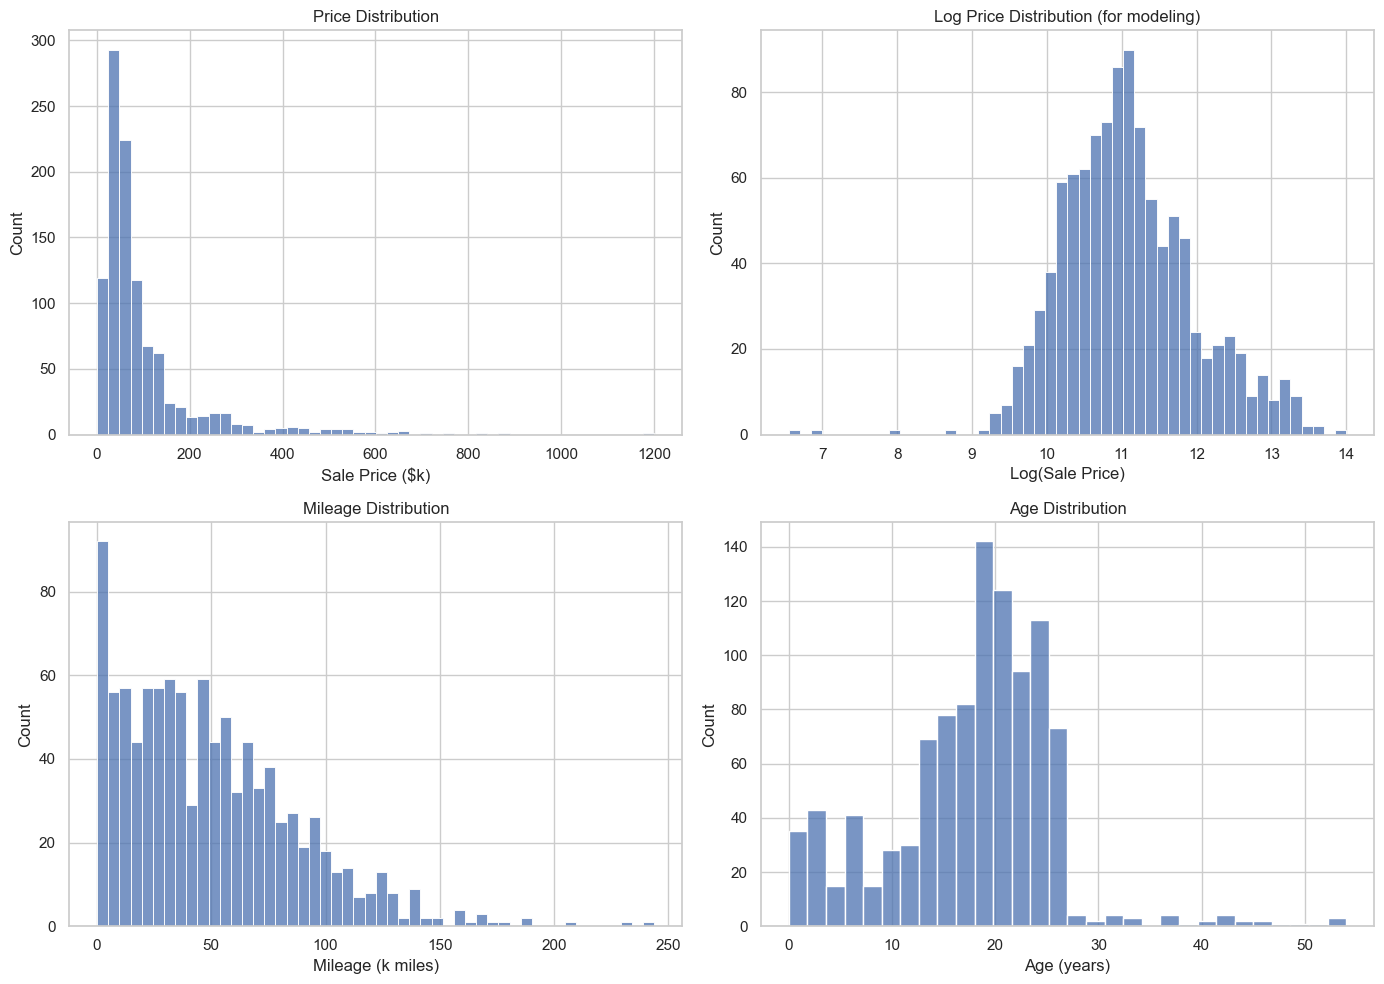

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price distribution
sns.histplot(df["sale_price"].dropna() / 1000, bins=50, ax=axes[0, 0])
axes[0, 0].set_xlabel("Sale Price ($k)")
axes[0, 0].set_title("Price Distribution")

# Log price distribution
sns.histplot(df["log_price"].dropna(), bins=50, ax=axes[0, 1])
axes[0, 1].set_xlabel("Log(Sale Price)")
axes[0, 1].set_title("Log Price Distribution (for modeling)")

# Mileage distribution
sns.histplot(df["mileage"].dropna() / 1000, bins=50, ax=axes[1, 0])
axes[1, 0].set_xlabel("Mileage (k miles)")
axes[1, 0].set_title("Mileage Distribution")

# Age distribution
sns.histplot(df["age"].dropna(), bins=30, ax=axes[1, 1])
axes[1, 1].set_xlabel("Age (years)")
axes[1, 1].set_title("Age Distribution")

plt.tight_layout()
plt.show()

## Categorical Counts

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


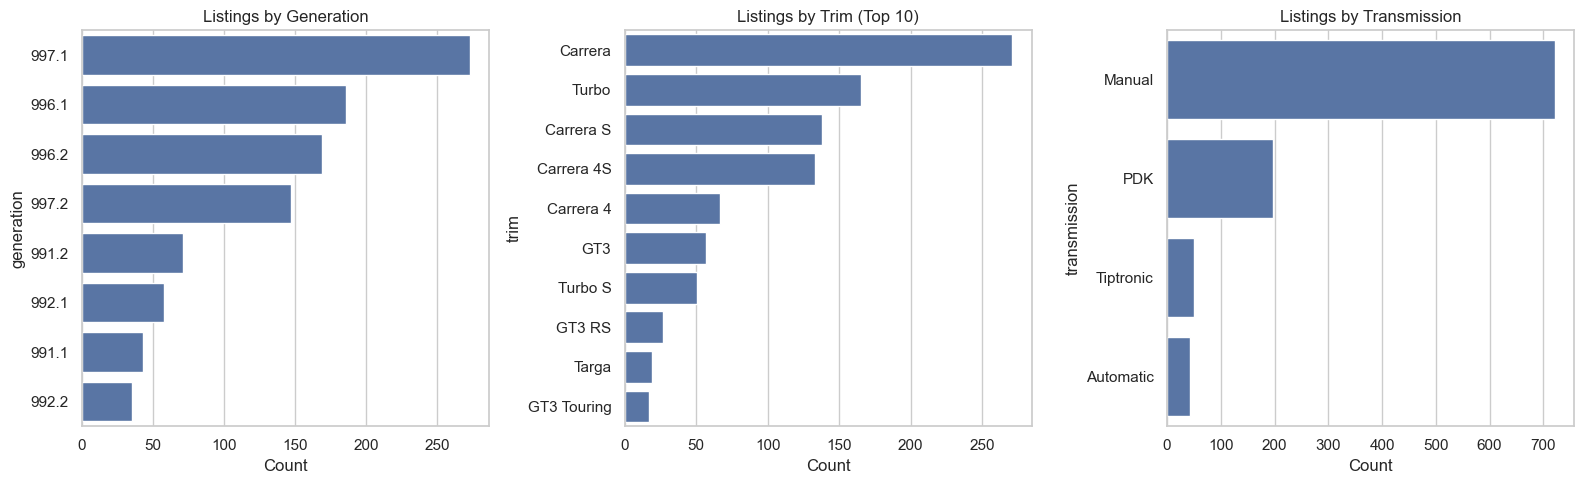

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Generation counts
gen_counts = df["generation"].value_counts()
sns.barplot(x=gen_counts.values, y=gen_counts.index, ax=axes[0], orient="h")
axes[0].set_title("Listings by Generation")
axes[0].set_xlabel("Count")

# Trim counts (top 10)
trim_counts = df["trim"].value_counts().head(10)
sns.barplot(x=trim_counts.values, y=trim_counts.index, ax=axes[1], orient="h")
axes[1].set_title("Listings by Trim (Top 10)")
axes[1].set_xlabel("Count")

# Transmission counts
trans_counts = df["transmission"].value_counts()
sns.barplot(x=trans_counts.values, y=trans_counts.index, ax=axes[2], orient="h")
axes[2].set_title("Listings by Transmission")
axes[2].set_xlabel("Count")

plt.tight_layout()
plt.show()

## Price by Model Year & Sale Date

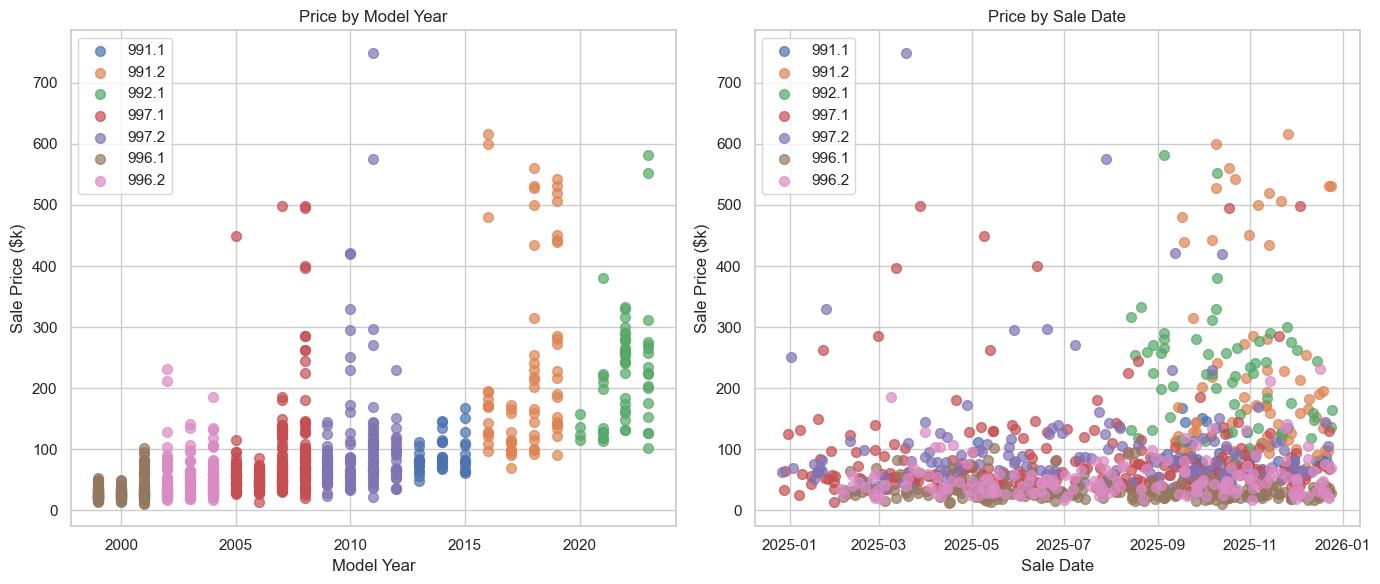

In [11]:
# Focus on key generations
key_gens = ["991.1", "991.2", "992.1", "997.1", "997.2", "996.1", "996.2"]
df_key = df[df["generation"].isin(key_gens)].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Price by model year (scatter)
ax = axes[0]
for gen in key_gens:
    subset = df_key[df_key["generation"] == gen]
    if len(subset) > 0:
        ax.scatter(
            subset["model_year"],
            subset["sale_price"] / 1000,
            label=gen,
            alpha=0.7,
            s=50,
        )
ax.set_xlabel("Model Year")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price by Model Year")
ax.legend()

# Price over sale time (if enough data)
ax = axes[1]
has_data = False
for gen in key_gens:
    subset = df_key[df_key["generation"] == gen]
    if len(subset) >= 2:  # Need at least 2 points to show trend
        ax.scatter(
            subset["sale_date"],
            subset["sale_price"] / 1000,
            label=gen,
            alpha=0.7,
            s=50,
        )
        has_data = True

if has_data:
    ax.set_xlabel("Sale Date")
    ax.set_ylabel("Sale Price ($k)")
    ax.set_title("Price by Sale Date")
    ax.legend()
else:
    ax.text(
        0.5,
        0.5,
        "Not enough data for time series",
        ha="center",
        va="center",
        transform=ax.transAxes,
    )
    ax.set_title("Price by Sale Date (insufficient data)")

plt.tight_layout()
plt.show()

## Price by Mileage

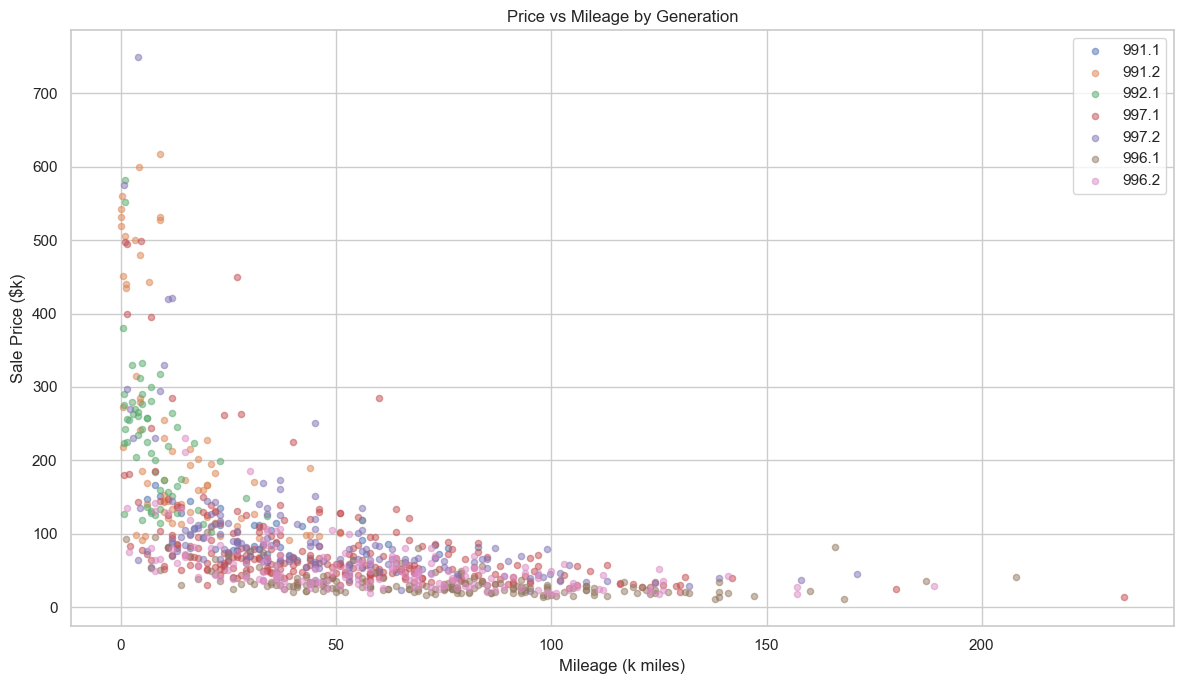

In [12]:
fig, ax = plt.subplots(figsize=(12, 7))
for gen in key_gens:
    subset = df_key[df_key["generation"] == gen]
    ax.scatter(
        subset["mileage"] / 1000,
        subset["sale_price"] / 1000,
        label=gen,
        alpha=0.5,
        s=20,
    )

ax.set_xlabel("Mileage (k miles)")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price vs Mileage by Generation")
ax.legend()
plt.tight_layout()
plt.show()

## Manual vs PDK Premium

In [13]:
# Compare manual vs PDK prices
# With small datasets, compare overall (not controlling for generation+trim)
trans_df = df[df["transmission"].isin(["Manual", "PDK"])].copy()

if len(trans_df) > 0:
    # Overall comparison
    print("=== Overall Manual vs PDK ===")
    overall = trans_df.groupby("transmission")["sale_price"].agg(["count", "median", "mean"])
    overall["median"] = overall["median"].apply(lambda x: f"${x:,.0f}")
    overall["mean"] = overall["mean"].apply(lambda x: f"${x:,.0f}")
    display(overall)

    # By generation (if enough data)
    print("\n=== By Generation (where both exist) ===")
    gen_trans = trans_df.groupby(["generation", "transmission"])["sale_price"].agg(
        ["count", "median"]
    )
    gen_trans_wide = gen_trans.unstack("transmission")
    # Only show where we have both Manual and PDK
    gen_trans_wide = gen_trans_wide.dropna()
    if len(gen_trans_wide) > 0:
        display(gen_trans_wide)
    else:
        print("Not enough data - need same generation with both Manual and PDK listings")
else:
    print("No Manual or PDK listings in dataset")

=== Overall Manual vs PDK ===


,count,median,mean
transmission,,,
Manual,721,"$56,500","$93,951"
PDK,197,"$112,000","$150,724"



=== By Generation (where both exist) ===


count          median          
transmission Manual   PDK    Manual       PDK
generation                                   
991.1           7.0  35.0   76000.0   82500.0
991.2          26.0  42.0  248000.0  148166.5
992.1          26.0  31.0  263750.0  200000.0
992.2          14.0  20.0  328000.0  360177.5
997.2          74.0  69.0   83000.0   66000.0

## Correlation Matrix

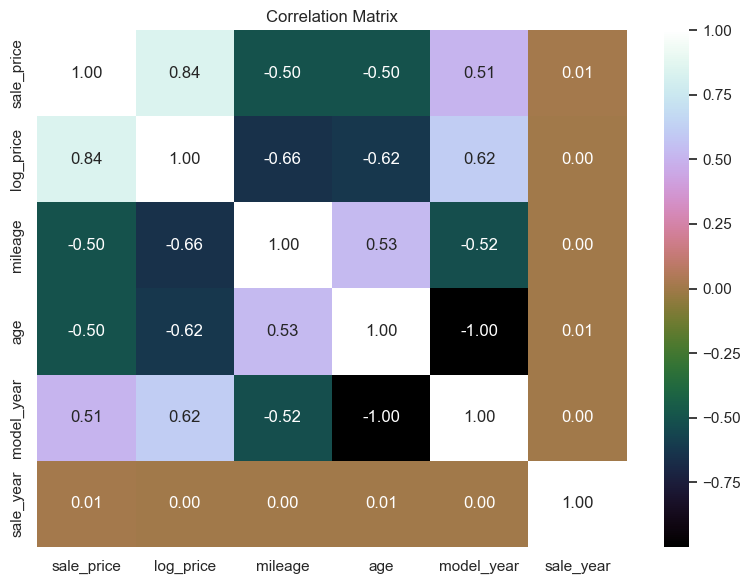

In [15]:
numeric_cols = ["sale_price", "log_price", "mileage", "age", "model_year", "sale_year"]
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="cubehelix", center=0, ax=ax)
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Filter & Group Data for Analysis

Focus on water-cooled 911s (996+) with simplified trim groupings:
- **Exclude GTs** (GT3, GT3 RS, GT2 RS, GT3 Touring) - analyzed separately
- **Combine Targas** with corresponding AWD coupes
- **Combine Turbo + Turbo S** into single "Turbo" tier

In [ ]:
# Define filter criteria
WATER_COOLED_GENS = ["996.1", "996.2", "997.1", "997.2", "991.1", "991.2", "992.1", "992.2"]
GT_TRIMS = ["GT3", "GT3 RS", "GT2 RS", "GT3 Touring"]

# Trim groupings: Targa → AWD coupe, Turbo S → Turbo
TRIM_MAPPING = {
    "Targa": "Carrera 4",
    "Targa 4": "Carrera 4",
    "Targa 4S": "Carrera 4S",
    "Turbo S": "Turbo",
}

# Create main analysis dataset (non-GT water-cooled)
df_main = df[
    df["generation"].isin(WATER_COOLED_GENS) &
    ~df["trim"].isin(GT_TRIMS) &
    df["trim"].notna()
].copy()

# Apply trim groupings
df_main["trim_grouped"] = df_main["trim"].replace(TRIM_MAPPING)

# Create GT dataset for separate analysis
df_gt = df[
    df["generation"].isin(WATER_COOLED_GENS) &
    df["trim"].isin(GT_TRIMS)
].copy()

print(f"Main analysis: {len(df_main)} listings (non-GT water-cooled)")
print(f"GT models: {len(df_gt)} listings")
print(f"\nTrim distribution (after grouping):")
display(df_main["trim_grouped"].value_counts().to_frame("count"))

## Price Relationships by Key Variables

Visual breakdowns of how price varies with age, mileage, trim, transmission, and generation.

In [ ]:
# Price by Age - scatter with trend and box plots (water-cooled non-GT)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter with regression line
ax = axes[0]
df_age = df_main[df_main["age"].notna()].copy()
sns.regplot(
    data=df_age,
    x="age",
    y=df_age["sale_price"] / 1000,
    scatter_kws={"alpha": 0.3, "s": 20},
    line_kws={"color": "red"},
    ax=ax,
)
ax.set_xlabel("Age (years)")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price vs Age (water-cooled non-GT)")

# Box plot by age buckets
ax = axes[1]
df_age["age_bucket"] = pd.cut(
    df_age["age"],
    bins=[0, 5, 10, 15, 20, 25, 30],
    labels=["0-5", "5-10", "10-15", "15-20", "20-25", "25-30"],
)
order = ["0-5", "5-10", "10-15", "15-20", "20-25", "25-30"]
sns.boxplot(
    data=df_age,
    x="age_bucket",
    y=df_age["sale_price"] / 1000,
    order=order,
    ax=ax,
)
ax.set_xlabel("Age (years)")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price Distribution by Age Bucket")

plt.tight_layout()
plt.show()

In [ ]:
# Price by Mileage - scatter with regression by generation (water-cooled non-GT)
fig, ax = plt.subplots(figsize=(14, 7))

df_mileage = df_main[df_main["mileage"].notna()].copy()
df_mileage["mileage_k"] = df_mileage["mileage"] / 1000
df_mileage["price_k"] = df_mileage["sale_price"] / 1000

sns.scatterplot(
    data=df_mileage,
    x="mileage_k",
    y="price_k",
    hue="generation",
    hue_order=WATER_COOLED_GENS,
    alpha=0.6,
    s=50,
    ax=ax,
)
# Overall trend line
sns.regplot(
    data=df_mileage,
    x="mileage_k",
    y="price_k",
    scatter=False,
    color="black",
    line_kws={"linestyle": "--", "label": "Overall trend"},
    ax=ax,
)
ax.set_xlabel("Mileage (k miles)")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price vs Mileage by Generation (water-cooled non-GT)")
ax.legend(title="Generation", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
# Price by Trim (grouped) - box plots ordered by median price
fig, ax = plt.subplots(figsize=(12, 7))

trim_order = df_main.groupby("trim_grouped")["sale_price"].median().sort_values(ascending=False).index

sns.boxplot(
    data=df_main,
    x="trim_grouped",
    y=df_main["sale_price"] / 1000,
    order=trim_order,
    palette="viridis",
    ax=ax,
)
sns.stripplot(
    data=df_main,
    x="trim_grouped",
    y=df_main["sale_price"] / 1000,
    order=trim_order,
    color="black",
    alpha=0.2,
    size=3,
    ax=ax,
)
ax.set_xlabel("Trim (grouped)")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price Distribution by Trim (Targa→AWD, Turbo S→Turbo)")
ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

# Summary stats
print("Listings per trim (grouped):")
trim_stats = df_main.groupby("trim_grouped")["sale_price"].agg(["count", "median", "mean"])
trim_stats = trim_stats.sort_values("median", ascending=False)
trim_stats["median"] = trim_stats["median"].apply(lambda x: f"${x:,.0f}")
trim_stats["mean"] = trim_stats["mean"].apply(lambda x: f"${x:,.0f}")
display(trim_stats)

In [ ]:
# Price by Transmission - box plots (water-cooled non-GT)
fig, ax = plt.subplots(figsize=(10, 6))

df_trans = df_main[df_main["transmission"].notna()].copy()
trans_order = ["Manual", "PDK", "Automatic", "Tiptronic"]
trans_order = [t for t in trans_order if t in df_trans["transmission"].values]

sns.boxplot(
    data=df_trans,
    x="transmission",
    y=df_trans["sale_price"] / 1000,
    order=trans_order,
    palette="Set2",
    ax=ax,
)
sns.stripplot(
    data=df_trans,
    x="transmission",
    y=df_trans["sale_price"] / 1000,
    order=trans_order,
    color="black",
    alpha=0.3,
    size=3,
    ax=ax,
)
ax.set_xlabel("Transmission")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price Distribution by Transmission (water-cooled non-GT)")
plt.tight_layout()
plt.show()

# Summary stats
print("Price by Transmission:")
trans_stats = df_trans.groupby("transmission")["sale_price"].agg(["count", "median", "mean"])
trans_stats["median"] = trans_stats["median"].apply(lambda x: f"${x:,.0f}")
trans_stats["mean"] = trans_stats["mean"].apply(lambda x: f"${x:,.0f}")
display(trans_stats)

In [ ]:
# Price by Generation - box plots (water-cooled non-GT)
fig, ax = plt.subplots(figsize=(12, 7))

sns.boxplot(
    data=df_main,
    x="generation",
    y=df_main["sale_price"] / 1000,
    order=WATER_COOLED_GENS,
    palette="coolwarm",
    ax=ax,
)
sns.stripplot(
    data=df_main,
    x="generation",
    y=df_main["sale_price"] / 1000,
    order=WATER_COOLED_GENS,
    color="black",
    alpha=0.2,
    size=3,
    ax=ax,
)
ax.set_xlabel("Generation (chronological)")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price Distribution by Generation (water-cooled non-GT)")
plt.tight_layout()
plt.show()

# Summary stats
print("Price by Generation:")
gen_stats = df_main.groupby("generation")["sale_price"].agg(["count", "median", "mean"])
gen_stats = gen_stats.reindex(WATER_COOLED_GENS)
gen_stats["median"] = gen_stats["median"].apply(lambda x: f"${x:,.0f}")
gen_stats["mean"] = gen_stats["mean"].apply(lambda x: f"${x:,.0f}")
display(gen_stats)

In [ ]:
# Faceted: Price vs Age by Generation (water-cooled non-GT)
df_facet = df_main[df_main["age"].notna()].copy()
df_facet["price_k"] = df_facet["sale_price"] / 1000

g = sns.FacetGrid(
    df_facet,
    col="generation",
    col_wrap=4,
    height=4,
    aspect=1.2,
    col_order=WATER_COOLED_GENS,
)
g.map_dataframe(sns.regplot, x="age", y="price_k", scatter_kws={"alpha": 0.5, "s": 30}, line_kws={"color": "red"})
g.set_axis_labels("Age (years)", "Price ($k)")
g.set_titles("{col_name}")
g.fig.suptitle("Price vs Age by Generation (water-cooled non-GT)", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Heatmap: Median price by Generation × Trim (grouped, water-cooled non-GT)
pivot = df_main.pivot_table(
    values="sale_price",
    index="trim_grouped",
    columns="generation",
    aggfunc="median",
)
# Reorder columns chronologically
col_order = [c for c in WATER_COOLED_GENS if c in pivot.columns]
pivot = pivot[col_order]

# Only show trims with at least 2 generations of data
pivot = pivot.dropna(thresh=2)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(
    pivot / 1000,
    annot=True,
    fmt=".0f",
    cmap="YlOrRd",
    cbar_kws={"label": "Median Price ($k)"},
    ax=ax,
)
ax.set_title("Median Price by Generation × Trim ($k) - water-cooled non-GT")
ax.set_xlabel("Generation")
ax.set_ylabel("Trim (grouped)")
plt.tight_layout()
plt.show()

In [ ]:
# LOWESS curves: Price vs Age (water-cooled non-GT)
from statsmodels.nonparametric.smoothers_lowess import lowess

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_lowess = df_main[df_main["age"].notna() & df_main["log_price"].notna()].copy().sort_values("age")

# Left: Log scale price (more linear relationship expected)
ax = axes[0]
ax.scatter(df_lowess["age"], df_lowess["log_price"], alpha=0.3, s=20, label="Data")
lowess_fit = lowess(df_lowess["log_price"], df_lowess["age"], frac=0.3)
ax.plot(lowess_fit[:, 0], lowess_fit[:, 1], "r-", linewidth=2, label="LOWESS")
ax.set_xlabel("Age (years)")
ax.set_ylabel("Log(Sale Price)")
ax.set_title("Log Price vs Age (LOWESS) - water-cooled non-GT")
ax.legend()

# Right: Linear scale (shows non-linearity more dramatically)
ax = axes[1]
df_lowess["price_k"] = df_lowess["sale_price"] / 1000
ax.scatter(df_lowess["age"], df_lowess["price_k"], alpha=0.3, s=20, label="Data")
lowess_fit_linear = lowess(df_lowess["price_k"], df_lowess["age"], frac=0.3)
ax.plot(lowess_fit_linear[:, 0], lowess_fit_linear[:, 1], "r-", linewidth=2, label="LOWESS")
ax.set_xlabel("Age (years)")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price vs Age (LOWESS) - Linear Scale")
ax.legend()

plt.tight_layout()
plt.show()

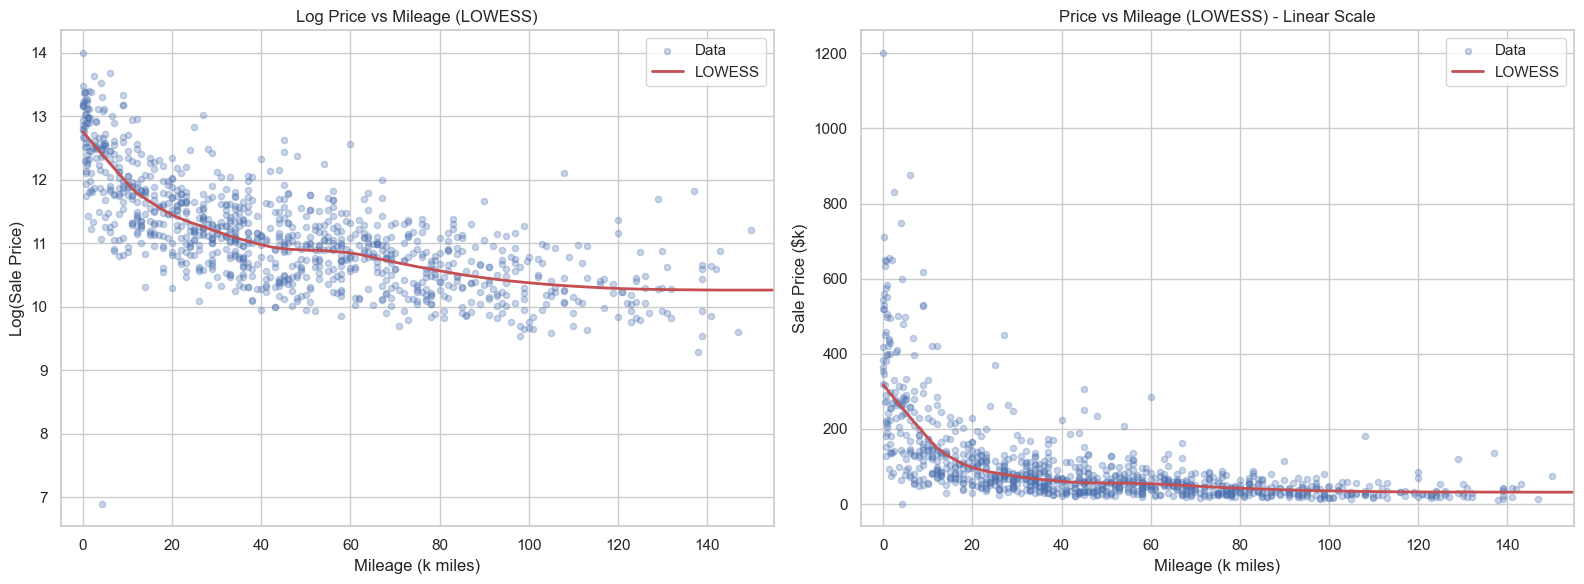

In [28]:
# LOWESS: Price vs Mileage
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_mileage_lowess = df[df["mileage"].notna() & df["log_price"].notna()].copy()
df_mileage_lowess = df_mileage_lowess.sort_values("mileage")
df_mileage_lowess["mileage_k"] = df_mileage_lowess["mileage"] / 1000
df_mileage_lowess["price_k"] = df_mileage_lowess["sale_price"] / 1000

# Log scale
ax = axes[0]
ax.scatter(df_mileage_lowess["mileage_k"], df_mileage_lowess["log_price"], alpha=0.3, s=20, label="Data")
lowess_fit = lowess(df_mileage_lowess["log_price"], df_mileage_lowess["mileage_k"], frac=0.3)
ax.plot(lowess_fit[:, 0], lowess_fit[:, 1], "r-", linewidth=2, label="LOWESS")
ax.set_xlabel("Mileage (k miles)")
ax.set_ylabel("Log(Sale Price)")
ax.set_title("Log Price vs Mileage (LOWESS)")
ax.set_xlim(-5, 155)
ax.legend()

# Linear scale
ax = axes[1]
ax.scatter(df_mileage_lowess["mileage_k"], df_mileage_lowess["price_k"], alpha=0.3, s=20, label="Data")
lowess_fit_linear = lowess(df_mileage_lowess["price_k"], df_mileage_lowess["mileage_k"], frac=0.3)
ax.plot(lowess_fit_linear[:, 0], lowess_fit_linear[:, 1], "r-", linewidth=2, label="LOWESS")
ax.set_xlabel("Mileage (k miles)")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price vs Mileage (LOWESS) - Linear Scale")
ax.set_xlim(-5, 155)
ax.legend()

plt.tight_layout()
plt.show()

## Prepare Model-Ready Data

In [29]:
df_model = prepare_model_data(df)
print(f"Model-ready data: {len(df_model)} listings")
display(df_model.head())

INFO:price_analysis.data.cleaning:Model-ready dataset: 929 listings (from 1053 cleaned)


Model-ready data: 929 listings


,listing_url,title_raw,sale_price,sale_date,model_year,generation,trim,transmission,mileage,color,location,sale_year,age,mileage_10k,mileage_scaled,color_category,log_price,is_valid
7,https://bringatrailer.com/listing/2020-porsche...,6k-Mile 2020 Porsche 911 Carrera 4S Coupe,137000,2025-12-24,2020,992.1,Carrera 4S,PDK,6000,Aventurine Green Metallic,"Phoenix, Arizona 85018",2025.0,5.0,0.6,-1.14464,standard,11.827736,True
11,https://bringatrailer.com/listing/2024-porsche...,2024 Porsche 911 GT3 Touring 6-Speed,272000,2025-12-23,2024,992.2,GT3 Touring,Manual,3000,Chalk,"Wellesley, Massachusetts 02482",2025.0,1.0,0.3,-1.223581,special,12.513557,True
12,https://bringatrailer.com/listing/2018-porsche...,Signal Green 2018 Porsche 911 GT2 RS Weissach,531111,2025-12-24,2018,991.2,GT2 RS,PDK,9000,-to-Sample Signal Green,"Naperville, Illinois 60563",2025.0,7.0,0.9,-1.065699,special,13.182726,True
14,https://bringatrailer.com/listing/2022-porsche...,2022 Porsche 911 Carrera 4 GTS Cabriolet 7-Speed,165000,2025-12-25,2022,992.1,Carrera 4,Manual,13000,Jet Black Metallic,"Hollis, New York 11423",2025.0,3.0,1.3,-0.960444,standard,12.013701,True
17,https://bringatrailer.com/listing/2002-porsche...,2002 Porsche 911 Turbo Coupe 6-Speed,69000,2025-12-24,2002,996.2,Turbo,Manual,73000,Guards Red,"Frisco, Texas 75036",2025.0,23.0,7.3,0.618381,special,11.141862,True


In [30]:
# Save cleaned data
df.to_parquet(OUTPUT_PATH, index=False)
print(f"Saved cleaned data to {OUTPUT_PATH}")

Saved cleaned data to ../data/processed/cleaned_listings.parquet
